# Airline Customer Analytics

**Data Feature Exploration**

**Date:** 20 Jan, 2026

---

## Importing Required Packages

In [1]:
# --- Data Analysis ---
import pandas as pd

# --- Data Visualization ---
import matplotlib.pyplot as plt

---

## Exploratory Data Analytics

### Load Data

In [2]:
cfa_df = pd.read_parquet(
    "../data/processed/cfa.parquet",
    engine="pyarrow"
)

cfa_df.head()

,loyalty_number,year,month,total_flights,distance,points_accumulated,points_redeemed,dollar_cost_points_redeemed
0,100590,2018,6,12,15276,22914.0,0,0
1,100590,2018,7,12,9168,13752.0,0,0
2,100590,2018,5,4,6504,9756.0,0,0
3,100590,2018,10,0,0,0.0,512,92
4,100590,2018,2,0,0,0.0,0,0


In [3]:
clh_df = pd.read_parquet(
    "../data/processed/clh.parquet",
    engine="pyarrow"
)

clh_df.head()

,loyalty_number,country,province,city,postal_code,gender,education,salary,marital_status,loyalty_card,clv,enrollment_type,enrollment_year,enrollment_month,cancellation_year,cancellation_month
0,480934,Canada,Ontario,Toronto,M2Z 4K1,Female,Bachelor,83236.0,Married,Star,3839.14,Standard,2016,2,<NA>,<NA>
1,549612,Canada,Alberta,Edmonton,T3G 6Y6,Male,College,NaN,Divorced,Star,3839.61,Standard,2016,3,<NA>,<NA>
2,429460,Canada,British Columbia,Vancouver,V6E 3D9,Male,College,NaN,Single,Star,3839.75,Standard,2014,7,2018,1
3,608370,Canada,Ontario,Toronto,P1W 1K4,Male,College,NaN,Single,Star,3839.75,Standard,2013,2,<NA>,<NA>
4,530508,Canada,Quebec,Hull,J8Y 3Z5,Male,Bachelor,103495.0,Married,Star,3842.79,Standard,2014,10,<NA>,<NA>


### Total No of Customers

In [4]:
clh_df["loyalty_number"].nunique()

16737

### Recency

In [5]:
cfa_df['activity_date'] = pd.to_datetime(
    dict(year=cfa_df['year'], month=cfa_df['month'], day=1)
)

max_activity_date = cfa_df["activity_date"].max()

customers = cfa_df[['loyalty_number']].drop_duplicates()

In [6]:

recent_activity = (
    cfa_df[cfa_df['total_flights'] > 0]
    .sort_values('activity_date')
    .groupby('loyalty_number', as_index=False)
    .last()[['loyalty_number', 'activity_date', 'total_flights']]
)

recent_activity["recency"] = (
    (max_activity_date.year - recent_activity["activity_date"].dt.year) * 12
    + (max_activity_date.month - recent_activity["activity_date"].dt.month)
)

customer_recency = customers.merge(
    recent_activity[['loyalty_number', 'recency']],
    on='loyalty_number',
    how='left'
)

max_recency = customer_recency['recency'].max()
customer_recency['recency'] = (
    customer_recency['recency'].fillna(max_recency + 1)
)

max_r = customer_recency['recency'].max()
min_r = customer_recency['recency'].min()

customer_recency['recency_score_continuous'] = (
    1 - (customer_recency['recency'] - min_r) / (max_r - min_r)
).round(3)

customer_recency['recency_score_discrete'] = pd.cut(
    customer_recency['recency'],
    bins=[-1, 1, 3, 6, 12, 24],
    labels=[5, 4, 3, 2, 1]
)

customer_recency.head()

,loyalty_number,recency,recency_score_continuous,recency_score_discrete
0,100590,5.0,0.792,3
1,102376,0.0,1.000,5
2,102788,0.0,1.000,5
3,104267,0.0,1.000,5
4,105063,1.0,0.958,5


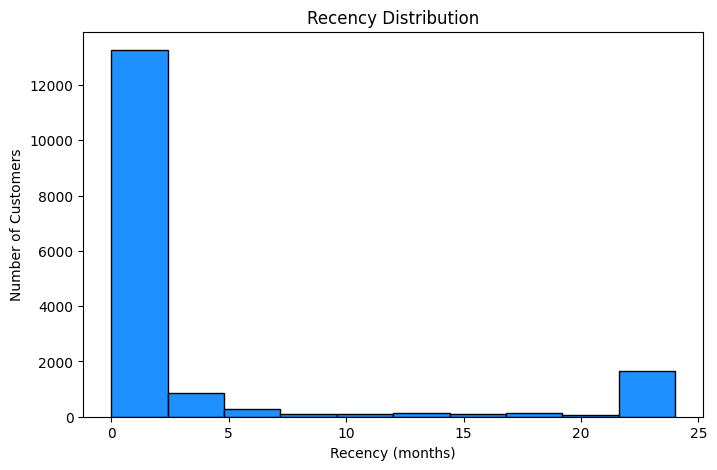

In [7]:
plt.figure(figsize=(8, 5))
plt.hist(customer_recency["recency"], bins=10, color="dodgerblue", edgecolor="black")
plt.title("Recency Distribution")
plt.xlabel("Recency (months)")
plt.ylabel("Number of Customers")
plt.show()

In [8]:
customer_recency["recency"].describe()

count    16737.000000
mean         3.561929
std          7.375618
min          0.000000
25%          0.000000
50%          0.000000
75%          2.000000
max         24.000000
Name: recency, dtype: float64

In [9]:
customer_recency.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16737 entries, 0 to 16736
Data columns (total 4 columns):
 #   Column                    Non-Null Count  Dtype   
---  ------                    --------------  -----   
 0   loyalty_number            16737 non-null  int64   
 1   recency                   16737 non-null  float64 
 2   recency_score_continuous  16737 non-null  float64 
 3   recency_score_discrete    16737 non-null  category
dtypes: category(1), float64(2), int64(1)
memory usage: 409.0 KB
